<a href="https://colab.research.google.com/github/ladyTootie/ACE-R-D/blob/main/MPL_Final_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and Preprocess UWF-ZeekData24 CSV files

In [8]:
#All libraries
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import f1_score
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


# Load the dataset
def load_uwf_zeek_data(base_path):
    """
    Load all UWF-ZeekData24 CSV files
    The labels are already in the CSV files (label_tactic, label_technique, etc.)

    Parameters:
    - base_path: Path to the folder containing CSV files

    Returns:
    - combined_df: DataFrame with all data
    """

    all_data = []

    print("Loading UWF-ZeekData24 dataset...")
    print("=" * 60)

    # Get all CSV files in the folder
    csv_files = glob.glob(os.path.join(base_path, '*.csv'))

    if not csv_files:
        raise ValueError(f"No CSV files found in {base_path}")

    print(f"Found {len(csv_files)} CSV files\n")

    for csv_file in csv_files:
        filename = os.path.basename(csv_file)

        try:
            df = pd.read_csv(csv_file)
            all_data.append(df)

            file_size = os.path.getsize(csv_file) / (1024 * 1024)  # Size in MB
            print(f"✓ Loaded {len(df):,} samples from {filename}")
            print(f"  Size: {file_size:.2f} MB")

        except Exception as e:
            print(f"✗ Error loading {filename}: {e}")

    if not all_data:
        raise ValueError("No data loaded successfully!")

    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)

    print("\n" + "=" * 60)
    print(f"✓ Total samples loaded: {len(combined_df):,}")

    # Use the existing label columns
    if 'label_tactic' in combined_df.columns:
        print(f"\n✓ Using 'label_tactic' column for attack categories")
        print(f"\nLabel distribution (label_tactic):")
        print(combined_df['label_tactic'].value_counts().to_string())

    if 'label_binary' in combined_df.columns:
        print(f"\nBinary label distribution (label_binary):")
        print(combined_df['label_binary'].value_counts().to_string())

    print("=" * 60)

    return combined_df

print("✓ Data loading function defined successfully!")

✓ Data loading function defined successfully!


In [9]:
# Set the correct path (based on your output)
base_path = '/content/UWF_ZeekData24/'

# Verify path
if os.path.exists(base_path):
    print(f"✓ Path verified: {base_path}\n")
else:
    print(f"✗ Path not found: {base_path}")

✓ Path verified: /content/UWF_ZeekData24/



In [10]:

# Load all UWF-ZeekData24 data
df = load_uwf_zeek_data(base_path)

# Display basic information
print("\n" + "=" * 60)
print("DATASET INFORMATION")
print("=" * 60)
print(f"Dataset shape: {df.shape}")
print(f"  Rows (samples): {df.shape[0]:,}")
print(f"  Columns (features): {df.shape[1]}")

print("\nColumn names:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")


Loading UWF-ZeekData24 dataset...
Found 6 CSV files

✓ Loaded 561 samples from UWF-ZeekData24csvInitial_Access.csv
  Size: 0.13 MB
✓ Loaded 47,906 samples from UWF-ZeekData24csvBenign.csv
  Size: 9.69 MB
✓ Loaded 326 samples from UWF-ZeekData24csvPrivilege_Escalation.csv
  Size: 0.08 MB
✓ Loaded 43,494 samples from UWF-ZeekData24csvCredential_Access.csv
  Size: 10.29 MB
✓ Loaded 326 samples from UWF-ZeekData24csvPersistence.csv
  Size: 0.07 MB
✓ Loaded 2,909 samples from UWF-ZeekData24csvReconnaissance.csv
  Size: 0.60 MB

✓ Total samples loaded: 95,522

✓ Using 'label_tactic' column for attack categories

Label distribution (label_tactic):
label_tactic
none                    47906
Credential Access       43494
Reconnaissance           2909
Initial Access            561
Privilege Escalation      326
Persistence               326

Binary label distribution (label_binary):
label_binary
False        47906
True         46403
Duplicate      970
True           243

DATASET INFORMATION
Datas

In [11]:
# Check what's in the label columns
print("=" * 60)
print("LABEL COLUMN ANALYSIS")
print("=" * 60)

# Check label_tactic
if 'label_tactic' in df.columns:
    print("\n1. LABEL_TACTIC (Main attack category):")
    print("-" * 60)
    tactic_counts = df['label_tactic'].value_counts()
    total = len(df)
    for label, count in tactic_counts.items():
        percentage = (count / total) * 100
        print(f"  {str(label):<30s}: {count:8,} ({percentage:5.2f}%)")

# Check label_technique
if 'label_technique' in df.columns:
    print("\n2. LABEL_TECHNIQUE (Specific technique):")
    print("-" * 60)
    technique_counts = df['label_technique'].value_counts()
    print(f"  Unique techniques: {len(technique_counts)}")
    print("\n  Top 10 techniques:")
    for label, count in technique_counts.head(10).items():
        print(f"    {str(label):<40s}: {count:8,}")

# Check label_binary
if 'label_binary' in df.columns:
    print("\n3. LABEL_BINARY (Attack vs Normal):")
    print("-" * 60)
    binary_counts = df['label_binary'].value_counts()
    for label, count in binary_counts.items():
        percentage = (count / total) * 100
        print(f"  {str(label):<30s}: {count:8,} ({percentage:5.2f}%)")

# Check label_cve
if 'label_cve' in df.columns:
    print("\n4. LABEL_CVE (CVE identifiers):")
    print("-" * 60)
    cve_counts = df['label_cve'].value_counts()
    non_null = df['label_cve'].notna().sum()
    print(f"  Samples with CVE labels: {non_null:,}")
    if non_null > 0:
        print("\n  Top CVEs:")
        for label, count in cve_counts.head(5).items():
            print(f"    {str(label):<40s}: {count:8,}")

print("\n" + "=" * 60)

LABEL COLUMN ANALYSIS

1. LABEL_TACTIC (Main attack category):
------------------------------------------------------------
  none                          :   47,906 (50.15%)
  Credential Access             :   43,494 (45.53%)
  Reconnaissance                :    2,909 ( 3.05%)
  Initial Access                :      561 ( 0.59%)
  Privilege Escalation          :      326 ( 0.34%)
  Persistence                   :      326 ( 0.34%)

2. LABEL_TECHNIQUE (Specific technique):
------------------------------------------------------------
  Unique techniques: 5

  Top 10 techniques:
    none                                    :   47,906
    T1110                                   :   43,494
    T1595                                   :    2,909
    Duplicate                               :      970
    T1190                                   :      243

3. LABEL_BINARY (Attack vs Normal):
------------------------------------------------------------
  False                         :   47,906 

In [12]:
# Use label_tactic as the main attack category
# This replaces the 'unknown' labels we had before

if 'label_tactic' in df.columns:
    # Create attack_category from label_tactic
    df['attack_category'] = df['label_tactic'].fillna('normal')

    # Clean up the labels (handle NaN, empty strings, etc.)
    df['attack_category'] = df['attack_category'].replace('', 'normal')
    df['attack_category'] = df['attack_category'].replace('nan', 'normal')

    #Replace 'none' with 'normal'
    df['attack_category'] = df['attack_category'].replace('none', 'normal')

    # Convert to lowercase and replace spaces/special chars for consistency
    df['attack_category'] = df['attack_category'].str.lower().str.replace(' ', '_').str.replace('-', '_')

    print("✓ Created 'attack_category' column from 'label_tactic'")
    print("\nFinal attack category distribution:")
    print("=" * 60)

    category_stats = df['attack_category'].value_counts()
    total = len(df)
    print(f"{'Category':<30s} {'Count':>10s} {'Percentage':>12s}")
    print("-" * 55)
    for category, count in category_stats.items():
        percentage = (count / total) * 100
        print(f"{category:<30s} {count:>10,} {percentage:>11.2f}%")

    print("=" * 60)
else:
    print("⚠ Warning: 'label_tactic' column not found!")
    print("  Available label columns:", [col for col in df.columns if 'label' in col.lower()])

✓ Created 'attack_category' column from 'label_tactic'

Final attack category distribution:
Category                            Count   Percentage
-------------------------------------------------------
normal                             47,906       50.15%
credential_access                  43,494       45.53%
reconnaissance                      2,909        3.05%
initial_access                        561        0.59%
privilege_escalation                  326        0.34%
persistence                           326        0.34%


In [13]:
# Show sample rows from each attack category
print("=" * 60)
print("SAMPLE DATA FROM EACH CATEGORY")
print("=" * 60)

# Get unique categories
categories = df['attack_category'].unique()

for category in sorted(categories):
    print(f"\n{category.upper()}:")
    print("-" * 60)

    # Get sample from this category
    sample = df[df['attack_category'] == category].head(2)

    # Display key columns
    display_cols = ['duration', 'proto', 'service', 'conn_state',
                   'orig_bytes', 'resp_bytes', 'label_technique', 'attack_category']
    display_cols = [col for col in display_cols if col in sample.columns]

    display(sample[display_cols])

SAMPLE DATA FROM EACH CATEGORY

CREDENTIAL_ACCESS:
------------------------------------------------------------


,duration,proto,service,conn_state,orig_bytes,resp_bytes,label_technique,attack_category
48793,0.006303,tcp,NaN,SF,0.0,0.0,T1110,credential_access
48794,0.007877,tcp,NaN,SF,0.0,0.0,T1110,credential_access



INITIAL_ACCESS:
------------------------------------------------------------


,duration,proto,service,conn_state,orig_bytes,resp_bytes,label_technique,attack_category
0,0.001114,tcp,NaN,S0,0.0,0.0,Duplicate,initial_access
1,0.001455,tcp,NaN,S0,0.0,0.0,Duplicate,initial_access



NORMAL:
------------------------------------------------------------


,duration,proto,service,conn_state,orig_bytes,resp_bytes,label_technique,attack_category
561,NaN,udp,dns,S0,NaN,NaN,none,normal
562,NaN,udp,dns,S0,NaN,NaN,none,normal



PERSISTENCE:
------------------------------------------------------------


,duration,proto,service,conn_state,orig_bytes,resp_bytes,label_technique,attack_category
92287,0.001274,tcp,NaN,S0,0.0,0.0,Duplicate,persistence
92288,0.001397,tcp,NaN,S0,0.0,0.0,Duplicate,persistence



PRIVILEGE_ESCALATION:
------------------------------------------------------------


,duration,proto,service,conn_state,orig_bytes,resp_bytes,label_technique,attack_category
48467,0.001274,tcp,NaN,S0,0.0,0.0,Duplicate,privilege_escalation
48468,0.001397,tcp,NaN,S0,0.0,0.0,Duplicate,privilege_escalation



RECONNAISSANCE:
------------------------------------------------------------


,duration,proto,service,conn_state,orig_bytes,resp_bytes,label_technique,attack_category
92613,NaN,tcp,NaN,OTH,NaN,NaN,T1595,reconnaissance
92614,NaN,tcp,NaN,OTH,NaN,NaN,T1595,reconnaissance


Define Preprocessing Function

In [14]:
def preprocess_uwf_data(df):
    """
    Preprocess UWF-ZeekData24 for machine learning

    Parameters:
    - df: Raw DataFrame with attack_category column

    Returns:
    - X: Feature DataFrame
    - y_encoded: Encoded labels
    - preprocessor: Fitted ColumnTransformer
    - label_encoder: Fitted LabelEncoder
    - all_features: List of feature column names
    """

    print("Preprocessing UWF-ZeekData24 dataset...")
    print("=" * 60)

    # Define categorical features (from Zeek logs)
    categorical_features = [
        'conn_state',   # CRITICAL: SF, S0, REJ, etc.
        'proto',        # tcp, udp, icmp
        'service',      # http, dns, ssh, etc.
        'history',      # Connection history flags
        'local_orig',   # Boolean: is originator local?
        'local_resp'    # Boolean: is responder local?
    ]

    # Define numerical features (from Zeek logs)
    numerical_features = [
        'duration',         # Connection duration
        'orig_bytes',       # Bytes from originator
        'resp_bytes',       # Bytes from responder
        'orig_pkts',        # Packets from originator
        'resp_pkts',        # Packets from responder
        'orig_ip_bytes',    # IP-level bytes from originator
        'resp_ip_bytes',    # IP-level bytes from responder
        'missed_bytes'      # Missing data (potential evasion)
    ]

    # Handle missing values
    print("Handling missing values...")
    for col in categorical_features:
        if col in df.columns:
            df[col] = df[col].fillna('unknown')
            df[col] = df[col].astype(str)

    for col in numerical_features:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Filter to only available features
    available_cat_features = [f for f in categorical_features if f in df.columns]
    available_num_features = [f for f in numerical_features if f in df.columns]

    print(f"\n✓ Categorical features ({len(available_cat_features)}): {available_cat_features}")
    print(f"✓ Numerical features ({len(available_num_features)}): {available_num_features}")

    all_features = available_cat_features + available_num_features

    # Prepare features and labels
    X = df[all_features].copy()
    y = df['attack_category']

    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), available_num_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
             available_cat_features)
        ])

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    print(f"\n✓ Features prepared: {len(all_features)} total")
    print(f"✓ Labels encoded: {len(label_encoder.classes_)} classes")
    print(f"  Classes: {label_encoder.classes_.tolist()}")
    print("=" * 60)

    return X, y_encoded, preprocessor, label_encoder, all_features

print("✓ Preprocessing function defined successfully!")

✓ Preprocessing function defined successfully!


Apply preprocessing

In [15]:
# Apply preprocessing
X, y, preprocessor, label_encoder, feature_columns = preprocess_uwf_data(df)

print("\n✓ Preprocessing complete!")
print(f"Feature matrix shape: {X.shape}")
print(f"Label vector shape: {y.shape}")
print(f"\nFeature columns: {feature_columns}")

Preprocessing UWF-ZeekData24 dataset...
Handling missing values...

✓ Categorical features (6): ['conn_state', 'proto', 'service', 'history', 'local_orig', 'local_resp']
✓ Numerical features (8): ['duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes', 'missed_bytes']

✓ Features prepared: 14 total
✓ Labels encoded: 6 classes
  Classes: ['credential_access', 'initial_access', 'normal', 'persistence', 'privilege_escalation', 'reconnaissance']

✓ Preprocessing complete!
Feature matrix shape: (95522, 14)
Label vector shape: (95522,)

Feature columns: ['conn_state', 'proto', 'service', 'history', 'local_orig', 'local_resp', 'duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes', 'missed_bytes']


Train-Test split


In [16]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Ensures each class is proportionally represented
)

print("Data split complete!")
print("=" * 60)
print(f"Training samples:   {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing samples:    {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")
print(f"Total samples:      {len(X):,}")
print("=" * 60)

# Show class distribution in training set
print("\nClass distribution in training set:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for idx, count in train_dist.items():
    class_name = label_encoder.classes_[idx]
    percentage = count / len(y_train) * 100
    print(f"  {class_name:20s}: {count:6,} ({percentage:5.2f}%)")

Data split complete!
Training samples:   76,417 (80.0%)
Testing samples:    19,105 (20.0%)
Total samples:      95,522

Class distribution in training set:
  credential_access   : 34,795 (45.53%)
  initial_access      :    449 ( 0.59%)
  normal              : 38,324 (50.15%)
  persistence         :    261 ( 0.34%)
  privilege_escalation:    261 ( 0.34%)
  reconnaissance      :  2,327 ( 3.05%)


Apply Transformation

In [17]:
# Fit preprocessor on training data and transform both sets
print("Applying preprocessing transformations...")

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("=" * 60)
print("✓ Preprocessing applied successfully!")
print(f"  Training shape:   {X_train_processed.shape}")
print(f"  Testing shape:    {X_test_processed.shape}")
print(f"  Number of features after encoding: {X_train_processed.shape[1]}")
print("=" * 60)

Applying preprocessing transformations...
✓ Preprocessing applied successfully!
  Training shape:   (76417, 92)
  Testing shape:    (19105, 92)
  Number of features after encoding: 92


Compute class weights

In [18]:
# Calculate class weights to handle imbalanced data
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights computed (to handle imbalance):")
print("=" * 60)
for idx, weight in class_weight_dict.items():
    class_name = label_encoder.classes_[idx]
    print(f"  {class_name:20s}: {weight:6.2f}")
print("=" * 60)
print("\n💡 Higher weights = model will focus more on these minority classes")

Class weights computed (to handle imbalance):
  credential_access   :   0.37
  initial_access      :  28.37
  normal              :   0.33
  persistence         :  48.80
  privilege_escalation:  48.80
  reconnaissance      :   5.47

💡 Higher weights = model will focus more on these minority classes


# Create the MLP Model


In [19]:
# Get dimensions
num_features = X_train_processed.shape[1]
num_classes = len(label_encoder.classes_)

print(f"Building MLP model with {num_features} input features and {num_classes} output classes...")

# Build Multi-Layer Perceptron (MLP)
model = Sequential([
    # Input layer + First hidden layer
    Dense(256, activation='relu', input_shape=(num_features,)),
    BatchNormalization(),
    Dropout(0.4),

    # Second hidden layer
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Third hidden layer
    Dense(64, activation='relu'),
    Dropout(0.2),

    # Fourth hidden layer
    Dense(32, activation='relu'),

    # Output layer
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "=" * 60)
print("MODEL ARCHITECTURE")
print("=" * 60)
model.summary()

Building MLP model with 92 input features and 6 output classes...

MODEL ARCHITECTURE


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        23,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,774 (268.65 KB)

 Trainable params: 68,006 (265.65 KB)

 Non-trainable params: 768 (3.00 KB)

# Train and Test the Model

In [20]:
# Train the model
print("\n" + "=" * 60)
print("TRAINING MODEL")
print("=" * 60)
print("Training with 20 epochs... This may take a few minutes.\n")

history = model.fit(
    X_train_processed,
    y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weight_dict,
    verbose=1
)

print("\n✓ Training complete!")


TRAINING MODEL
Training with 20 epochs... This may take a few minutes.

Epoch 1/20
956/956 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8864 - loss: 1.2828 - val_accuracy: 0.9422 - val_loss: 0.1698
Epoch 2/20
956/956 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9432 - loss: 0.8169 - val_accuracy: 0.9429 - val_loss: 0.1547
Epoch 3/20
956/956 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9485 - loss: 0.7795 - val_accuracy: 0.9608 - val_loss: 0.1458
Epoch 4/20
956/956 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9558 - loss: 0.7497 - val_accuracy: 0.9428 - val_loss: 0.1659
Epoch 5/20
956/956 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9543 - loss: 0.7729 - val_accuracy: 0.9600 - val_loss: 0.1535
Epoch 6/20
956/956 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9509 - loss: 0.7842 - val_accuracy: 0.9566 - val_loss: 0.1415
Epoch 7/20
956/956 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9542 - loss: 0.7882 - val_accuracy: 0.9424 - val_loss: 0.1709
Epoch 8/20
956/956 ━━━━━━━━━━

In [22]:
# Evaluate the model on test set
print("=" * 60)
print("TESTING MODEL")
print("=" * 60)

# Get test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test, verbose=1)

print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions (FIX: use predict + argmax instead of predict_classes)
y_pred_probs = model.predict(X_test_processed, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate F1 scores
f1_score_weighted = f1_score(y_test, y_pred, average='weighted')
f1_score_macro = f1_score(y_test, y_pred, average='macro')

print(f"\nF1 Score (weighted): {f1_score_weighted:.4f}")
print(f"F1 Score (macro): {f1_score_macro:.4f}")
print("=" * 60)

TESTING MODEL
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9592 - loss: 0.1409

Test Accuracy: 95.93%
Test Loss: 0.1451

F1 Score (weighted): 0.9715
F1 Score (macro): 0.5691


In [23]:
# Detailed classification report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


CLASSIFICATION REPORT
                      precision    recall  f1-score   support

   credential_access       1.00      1.00      1.00      8699
      initial_access       0.98      0.43      0.60       112
              normal       1.00      0.96      0.98      9582
         persistence       0.20      0.03      0.05        65
privilege_escalation       0.07      0.88      0.13        65
      reconnaissance       0.95      0.50      0.65       582

            accuracy                           0.96     19105
           macro avg       0.70      0.63      0.57     19105
        weighted avg       0.99      0.96      0.97     19105



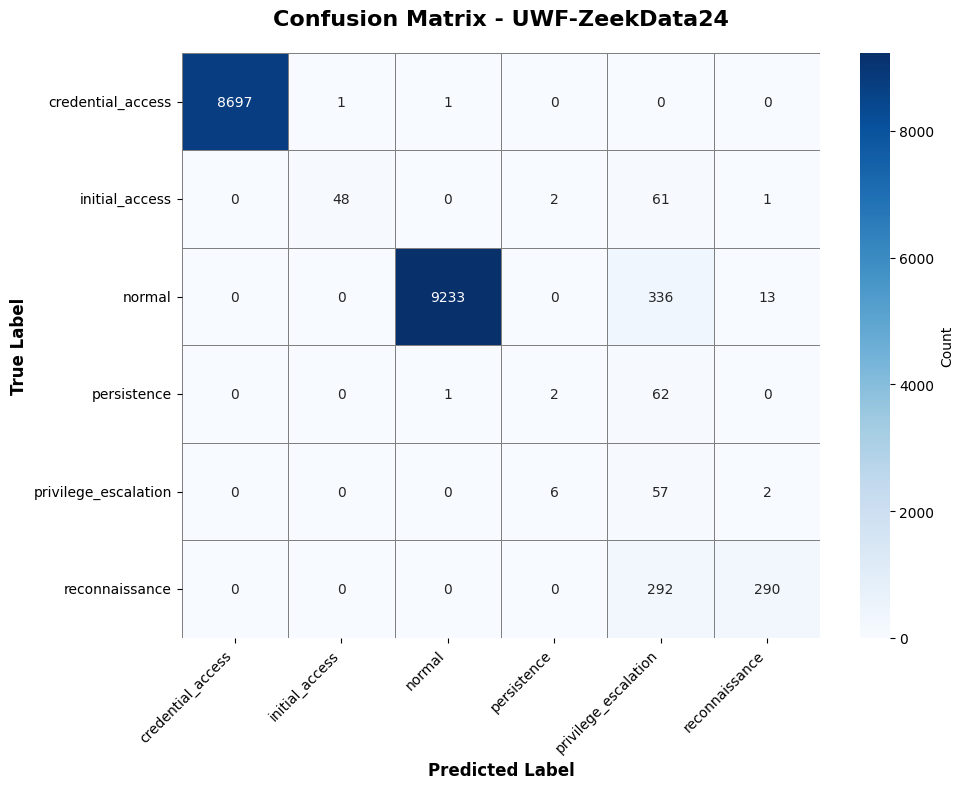

✓ Confusion matrix saved as 'confusion_matrix_uwf.png'


In [24]:
# Create and visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'},
            linewidths=0.5,
            linecolor='gray')

plt.title('Confusion Matrix - UWF-ZeekData24', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_uwf.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as 'confusion_matrix_uwf.png'")

#Save and load trained model

In [25]:
import joblib

# First, save your trained model and preprocessors if you haven't already
print("Saving model and preprocessors...")
model.save('uwf_zeek_ids_model.keras')
joblib.dump(preprocessor, 'uwf_preprocessor.pkl')
joblib.dump(label_encoder, 'uwf_label_encoder.pkl')
joblib.dump(feature_columns, 'uwf_feature_columns.pkl')
print("✓ Model and preprocessors saved!")

Saving model and preprocessors...
✓ Model and preprocessors saved!


# Preprocess the conn.log

In [26]:
def load_zeek_conn_log(log_path):
    """
    Load a Zeek conn.log file with proper header parsing

    Parameters:
    - log_path: Path to the conn.log file

    Returns:
    - log_df: DataFrame with parsed Zeek connection data
    - column_names: List of column names from the file
    """

    print(f"Loading conn.log from: {log_path}")
    print("=" * 60)

    # Parse Zeek header
    header_lines = []
    separator = '\t'
    column_names = []

    with open(log_path, 'r') as file:
        for line in file:
            if line.startswith('#separator'):
                raw_sep = line.split(' ', 1)[1].strip()
                separator = raw_sep.replace('\\x09', '\t')
            elif line.startswith('#fields'):
                fields_prefix = '#fields'
                if fields_prefix in line:
                    start_of_fields = line.find(fields_prefix) + len(fields_prefix)
                    fields_str_full = line[start_of_fields:].strip()
                    column_names = fields_str_full.split(separator)
                    column_names = [name for name in column_names if name]
            elif not line.startswith('#'):
                break
            header_lines.append(line)

    skip_lines = len(header_lines)

    # Load the data
    log_df = pd.read_csv(log_path, sep=separator, skiprows=skip_lines,
                         names=column_names, index_col=False)

    print(f"✓ Loaded {len(log_df):,} connections")
    print(f"✓ Columns found: {len(column_names)}")
    print("=" * 60)

    return log_df, column_names

print("✓ Conn.log loading function defined!")

✓ Conn.log loading function defined!


In [27]:
def preprocess_conn_log(log_df, preprocessor, feature_columns):
    """
    Preprocess conn.log to match UWF-ZeekData24 training format

    Parameters:
    - log_df: Raw conn.log DataFrame
    - preprocessor: Fitted preprocessor from training
    - feature_columns: List of feature names from training

    Returns:
    - log_features_processed: Preprocessed feature matrix ready for prediction
    - log_features: Original feature DataFrame (for display)
    """

    print("Preprocessing conn.log data...")
    print("=" * 60)

    # Map conn.log column names to UWF training feature names
    column_mapping = {
        # Conn.log name : Training feature name
        'proto': 'proto',
        'service': 'service',
        'duration': 'duration',
        'orig_bytes': 'orig_bytes',
        'resp_bytes': 'resp_bytes',
        'conn_state': 'conn_state',
        'local_orig': 'local_orig',
        'local_resp': 'local_resp',
        'missed_bytes': 'missed_bytes',
        'orig_pkts': 'orig_pkts',
        'resp_pkts': 'resp_pkts',
        'orig_ip_bytes': 'orig_ip_bytes',
        'resp_ip_bytes': 'resp_ip_bytes',
        'history': 'history'
    }

    # Create feature DataFrame with correct column names
    log_features = pd.DataFrame(index=log_df.index)

    # Map columns from conn.log to training format
    for conn_col, train_col in column_mapping.items():
        if conn_col in log_df.columns and train_col in feature_columns:
            log_features[train_col] = log_df[conn_col]

    # Fill missing features with appropriate defaults
    categorical_features = ['proto', 'service', 'conn_state', 'history', 'local_orig', 'local_resp']
    numerical_features = ['duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'resp_pkts',
                         'orig_ip_bytes', 'resp_ip_bytes', 'missed_bytes']

    for col in feature_columns:
        if col not in log_features.columns:
            if col in categorical_features:
                log_features[col] = 'unknown'
            else:
                log_features[col] = 0

    # Ensure all features are present and in correct order
    log_features = log_features[feature_columns]

    # Handle data types
    for col in log_features.columns:
        if col in categorical_features:
            log_features[col] = log_features[col].astype(str).fillna('unknown')
            # Replace '-' with 'unknown' (common in Zeek logs)
            log_features[col] = log_features[col].replace('-', 'unknown')
        else:
            log_features[col] = pd.to_numeric(log_features[col], errors='coerce').fillna(0)

    print(f"✓ Features mapped: {len(feature_columns)} features")
    print(f"✓ Categorical features filled with 'unknown' where missing")
    print(f"✓ Numerical features filled with 0 where missing")

    # Apply the same preprocessing transformations used in training
    log_features_processed = preprocessor.transform(log_features)

    print(f"✓ Preprocessing applied")
    print(f"  Processed shape: {log_features_processed.shape}")
    print("=" * 60)

    return log_features_processed, log_features

print("✓ Conn.log preprocessing function defined!")

✓ Conn.log preprocessing function defined!


In [33]:
# Set path to your conn.log file
conn_log_path = '/content/conn.log'  # Adjust this path

# Load the conn.log
log_df, log_columns = load_zeek_conn_log(conn_log_path)

# Display basic info
print("\nConn.log columns:")
print(log_columns)

print("\nFirst few rows:")
display(log_df.head())

Loading conn.log from: /content/conn.log


/tmp/ipython-input-248249427.py:40: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  log_df = pd.read_csv(log_path, sep=separator, skiprows=skip_lines,


✓ Loaded 1,286,476 connections
✓ Columns found: 22

Conn.log columns:
['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents', 'ip_proto']

First few rows:


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto
0,1763486223.331915,CRlD4K20lGRuvjA9Kd,155.89.17.0,2654.0,192.168.56.102,80.0,tcp,-,-,-,...,F,T,0.0,S,1.0,40.0,0.0,0.0,-,6.0
1,1763486223.332069,CO91j4XFy8N4lcgPb,243.118.166.93,2655.0,192.168.56.102,80.0,tcp,-,-,-,...,T,T,0.0,S,1.0,40.0,0.0,0.0,-,6.0
2,1763486223.33228,ClG94I1TXAOvF7Bv36,159.243.19.135,2656.0,192.168.56.102,80.0,tcp,-,-,-,...,F,T,0.0,S,1.0,40.0,0.0,0.0,-,6.0
3,1763486223.332338,CfI6k92FjOOKZy0pI5,143.161.38.105,2657.0,192.168.56.102,80.0,tcp,-,-,-,...,F,T,0.0,S,1.0,40.0,0.0,0.0,-,6.0
4,1763486223.332436,CNCUx5xvmQTJYk3X5,67.38.212.239,2658.0,192.168.56.102,80.0,tcp,-,-,-,...,F,T,0.0,S,1.0,40.0,0.0,0.0,-,6.0


In [34]:
# Preprocess the conn.log data
log_features_processed, log_features = preprocess_conn_log(
    log_df,
    preprocessor,
    feature_columns
)

print("\n✓ Conn.log ready for prediction!")
print(f"  Original conn.log: {log_df.shape}")
print(f"  Processed features: {log_features_processed.shape}")

Preprocessing conn.log data...
✓ Features mapped: 14 features
✓ Categorical features filled with 'unknown' where missing
✓ Numerical features filled with 0 where missing
✓ Preprocessing applied
  Processed shape: (1286476, 92)

✓ Conn.log ready for prediction!
  Original conn.log: (1286476, 22)
  Processed features: (1286476, 92)


# Predict Anomalies and Analyze Results

In [35]:
# Make predictions on conn.log
print("Making predictions on conn.log...")
print("=" * 60)

predictions = model.predict(log_features_processed, verbose=0)

# Get predicted classes and confidence scores
predicted_classes_idx = np.argmax(predictions, axis=1)
predicted_classes = label_encoder.inverse_transform(predicted_classes_idx)
prediction_confidence = np.max(predictions, axis=1)

# Get probabilities for each class
prob_df = pd.DataFrame(
    predictions,
    columns=[f'{cls}_prob' for cls in label_encoder.classes_]
)

# Add predictions to original dataframe
log_df['predicted_attack'] = predicted_classes
log_df['confidence'] = prediction_confidence
log_df['normal_probability'] = predictions[:, np.where(label_encoder.classes_ == 'normal')[0][0]]

print("✓ Predictions complete!")
print("=" * 60)

Making predictions on conn.log...
✓ Predictions complete!


In [36]:
# Analyze prediction results
print("\n" + "=" * 60)
print("PREDICTION RESULTS")
print("=" * 60)

total = len(log_df)
normal_count = (predicted_classes == 'normal').sum()
anomaly_count = total - normal_count

print(f"\nTotal connections analyzed: {total:,}")
print(f"Normal traffic: {normal_count:,} ({normal_count/total*100:.2f}%)")
print(f"Anomalies detected: {anomaly_count:,} ({anomaly_count/total*100:.2f}%)")

if anomaly_count > 0:
    print("\n" + "-" * 60)
    print("DETECTED ATTACK TYPES:")
    print("-" * 60)
    attack_dist = log_df[log_df['predicted_attack'] != 'normal']['predicted_attack'].value_counts()
    for attack_type, count in attack_dist.items():
        percentage = (count / anomaly_count) * 100
        print(f"  {attack_type:25s}: {count:6,} ({percentage:5.2f}%)")

    print("\n" + "-" * 60)
    print("SAMPLE OF DETECTED ANOMALIES:")
    print("-" * 60)

    # Show anomalies with relevant columns
    anomalies = log_df[log_df['predicted_attack'] != 'normal'].copy()

    display_cols = ['duration', 'proto', 'service', 'conn_state',
                   'orig_bytes', 'resp_bytes', 'predicted_attack',
                   'confidence', 'normal_probability']
    display_cols = [col for col in display_cols if col in anomalies.columns]

    print("\nTop 20 anomalies (by confidence):")
    display(anomalies.nlargest(20, 'confidence')[display_cols])

else:
    print("\n✓ No anomalies detected - all traffic appears normal")

    print("\n" + "-" * 60)
    print("SAMPLE OF NORMAL TRAFFIC:")
    print("-" * 60)

    display_cols = ['duration', 'proto', 'service', 'conn_state',
                   'orig_bytes', 'resp_bytes', 'normal_probability']
    display_cols = [col for col in display_cols if col in log_df.columns]

    print("\nSample connections with highest normal probability:")
    display(log_df.nlargest(10, 'normal_probability')[display_cols])

    print("\nSample connections with lowest normal probability:")
    display(log_df.nsmallest(10, 'normal_probability')[display_cols])

print("\n" + "=" * 60)


PREDICTION RESULTS

Total connections analyzed: 1,286,476
Normal traffic: 9 (0.00%)
Anomalies detected: 1,286,467 (100.00%)

------------------------------------------------------------
DETECTED ATTACK TYPES:
------------------------------------------------------------
  privilege_escalation     : 1,286,467 (100.00%)

------------------------------------------------------------
SAMPLE OF DETECTED ANOMALIES:
------------------------------------------------------------

Top 20 anomalies (by confidence):


,duration,proto,service,conn_state,orig_bytes,resp_bytes,predicted_attack,confidence,normal_probability
0,-,tcp,-,S0,-,-,privilege_escalation,0.327662,0.012455
1,-,tcp,-,S0,-,-,privilege_escalation,0.327662,0.012455
2,-,tcp,-,S0,-,-,privilege_escalation,0.327662,0.012455
3,-,tcp,-,S0,-,-,privilege_escalation,0.327662,0.012455
4,-,tcp,-,S0,-,-,privilege_escalation,0.327662,0.012455
5,-,tcp,-,S0,-,-,privilege_escalation,0.327662,0.012455
6,-,tcp,-,S0,-,-,privilege_escalation,0.327662,0.012455
7,-,tcp,-,S0,-,-,privilege_escalation,0.327662,0.012455
8,-,tcp,-,S0,-,-,privilege_escalation,0.327662,0.012455
9,-,tcp,-,S0,-,-,privilege_escalation,0.327662,0.012455


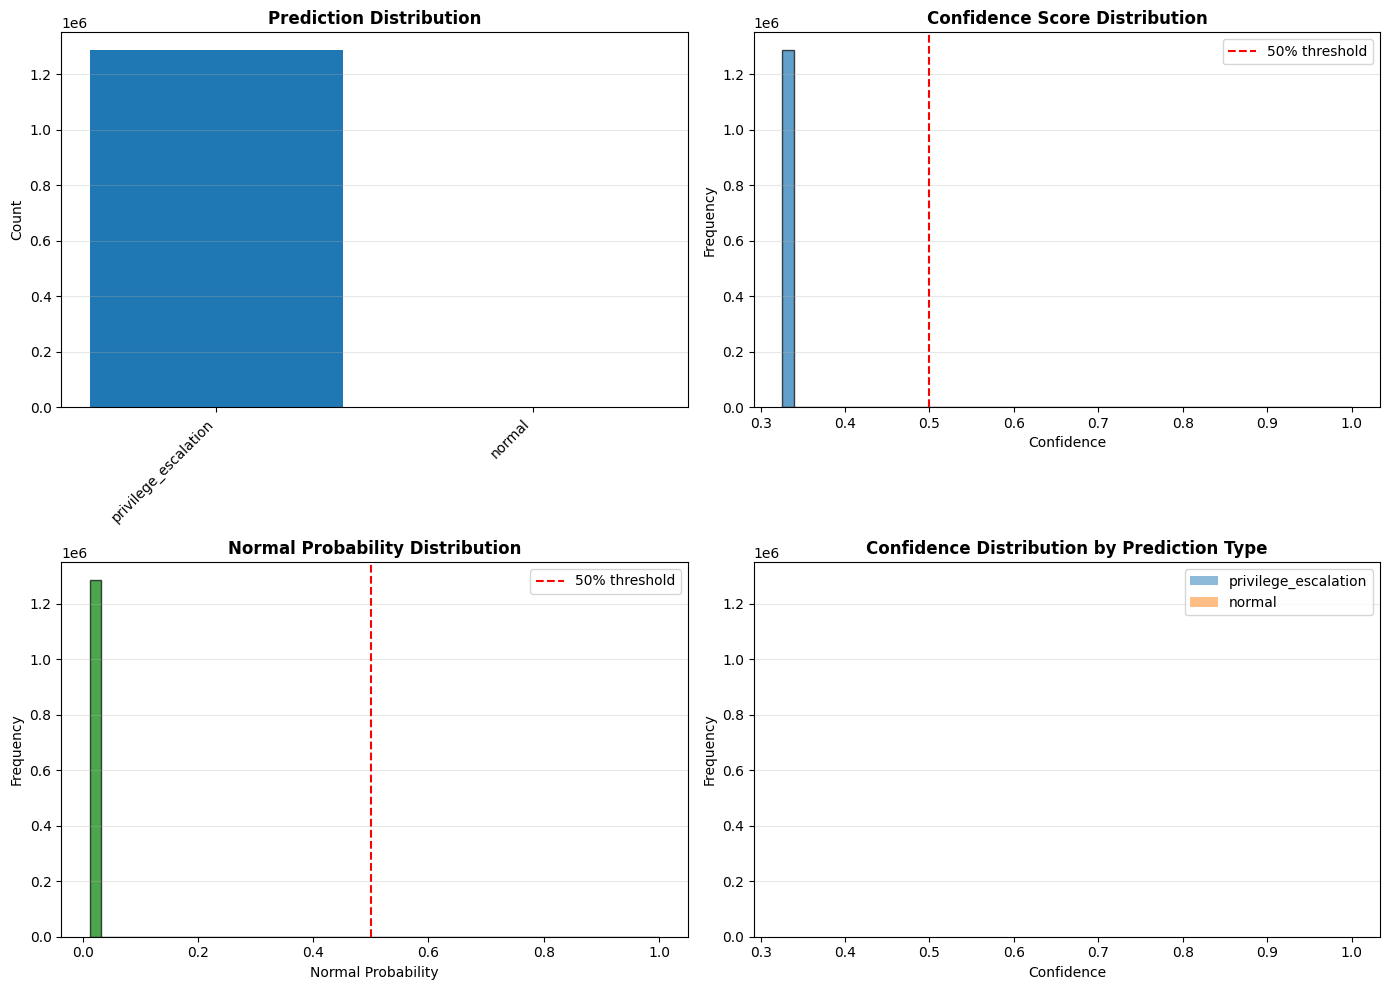

✓ Analysis plot saved as 'conn_log_predictions_analysis.png'


In [37]:
# Analyze confidence distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Prediction distribution
ax1 = axes[0, 0]
pred_counts = log_df['predicted_attack'].value_counts()
ax1.bar(range(len(pred_counts)), pred_counts.values)
ax1.set_xticks(range(len(pred_counts)))
ax1.set_xticklabels(pred_counts.index, rotation=45, ha='right')
ax1.set_title('Prediction Distribution', fontweight='bold')
ax1.set_ylabel('Count')
ax1.grid(axis='y', alpha=0.3)

# 2. Confidence score distribution
ax2 = axes[0, 1]
ax2.hist(log_df['confidence'], bins=50, edgecolor='black', alpha=0.7)
ax2.set_title('Confidence Score Distribution', fontweight='bold')
ax2.set_xlabel('Confidence')
ax2.set_ylabel('Frequency')
ax2.axvline(x=0.5, color='r', linestyle='--', label='50% threshold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Normal probability distribution
ax3 = axes[1, 0]
ax3.hist(log_df['normal_probability'], bins=50, edgecolor='black', alpha=0.7, color='green')
ax3.set_title('Normal Probability Distribution', fontweight='bold')
ax3.set_xlabel('Normal Probability')
ax3.set_ylabel('Frequency')
ax3.axvline(x=0.5, color='r', linestyle='--', label='50% threshold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Confidence by prediction type
ax4 = axes[1, 1]
for pred_type in log_df['predicted_attack'].unique():
    subset = log_df[log_df['predicted_attack'] == pred_type]['confidence']
    ax4.hist(subset, alpha=0.5, label=pred_type, bins=30)
ax4.set_title('Confidence Distribution by Prediction Type', fontweight='bold')
ax4.set_xlabel('Confidence')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('conn_log_predictions_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Analysis plot saved as 'conn_log_predictions_analysis.png'")